# Model simulation and parameter fitting

This file contains codes for the implementation of Section 3 of the paper: GNGARCH Model Specification and Simulation Results. Here we would do the simulation on GNGARCH($1,1,[1],[1]$) (with normal assumption on the strong white noise) on a specific 5-node network, with total 5000 samples generated and discard the first 20% samples (i.e. 1000 burnin samples).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps

from statsmodels.stats.correlation_tools import cov_nearest
from scipy.stats import norm, gaussian_kde, kurtosis, skew, probplot
from scipy.linalg import solve_triangular
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf
from statsmodels.stats.stattools import jarque_bera
from matplotlib.patches import Patch

import seaborn as sns
import statsmodels.api as sm

from statsmodels.tsa.stattools import adfuller
import os
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

import networkx as nx

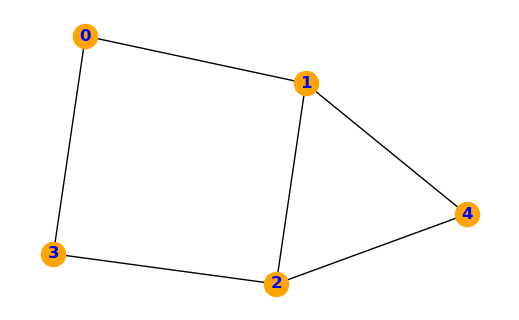

In [2]:
# First generate the simulation network
plt.figure(figsize=(5, 3))

# Define edges
edges = [(0, 1), (0, 3), (1, 2), (1, 4), (2, 4), (2, 3)]

# Create graph and add edges
G = nx.Graph()
G.add_edges_from(edges)

# Draw the graph
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_color='orange', edge_color='black', font_color='blue', font_weight='bold')
plt.show()

## Model simulation

In [3]:
def r_stage_node_weight_matrix(G, r):
    """
    Compute the r-stage neighbourhood node weight matrix W^(r) for a network G.
    See the definition of r-stage node weight matrix in the paper.

    Args:
        G (nx.Graph): An unweighted undirected graph.
        r (int): The neighbourhood order (distance) to consider.

    Returns:
        W (np.ndarray): The row-normalized weight matrix for r-stage neighbours. Nodes are ordered according to G.nodes().
    """
    
    nodes = sorted(list(G.nodes()))  # correct ascending order
    d = len(nodes)
    idx = {node: i for i, node in enumerate(nodes)}
    W = np.zeros((d, d), dtype=float)

    # Precompute all shortest‐path lengths up to distance r
    spl = dict(nx.all_pairs_shortest_path_length(G, cutoff=r))

    for i, u in enumerate(nodes):
        # Find r‐stage neighbours
        neigh_r = [v for v, d in spl.get(u, {}).items() if d == r]
        if not neigh_r:
            # if no r‐neighbours, skip (all zeros in that row)
            continue
        # Fetch tilde‐weights
        tilde = []
        for v in neigh_r:
            data = G.get_edge_data(u, v) or {}
            tilde_w = data.get('weight', 1.0)
            tilde.append(tilde_w)

        tilde = np.array(tilde, dtype=float)
        total = tilde.sum()
        if total == 0:
            # Equal weights (unweighted network)
            weights = np.ones_like(tilde) / len(tilde)
        else:
            # Weighted network
            weights = tilde / total

        # Fill row i in W
        for v, w in zip(neigh_r, weights):
            j = idx[v]
            W[i, j] = w

    return W

In [4]:
def node_weight_matrix(G):
    """Generate the total node weight matrix W, as the sum of all non-zero r-stage node weight matrices.

    Args:
        G (nx.Graph): An unweighted undirected graph.
    Returns:
        W_total (np.ndarray): The overall node weight matrix for the network G. 
    """
    
    nodes = list(G.nodes())
    d = len(nodes)
    # Initialise the total node weight matrix W_total
    W_total = np.zeros((d, d), dtype=float)
    
    # Initialise r=1 for the first stage node weight matrix
    r = 1
    
    while True:
        W_r = r_stage_node_weight_matrix(G, r)
        # If W_r has no non-zero entries (all entries are zero), break
        # this can be done by using np.any OR logic gate
        if not np.any(W_r):
            break
        # Otherwise accumulate and move to next r
        W_total += W_r
        r += 1

    return W_total

In [5]:
# Build a random spatial weight matrix W (zero diagonal, row-normalized)
# for simplicity we assume the equal edge weights setting, with the graph showing in GNAR review notes
W_sim = node_weight_matrix(G)
S1_sim = nx.to_numpy_array(G, nodelist=np.arange(0,5), dtype=int)  # for 1-st stage it is just adjacency matrix

# Choose some initial GNGARCH(1,1,[1],[1]) parameters
params_example = {
    'alpha0': 0.05,
    'alpha1': 0.20,
    'gamma1': 0.60,
    'beta11': 0.05,
    'delta11': 0.05
}

# Pick a set of explosive parameter
params_divergent = {
    'alpha0': 0.06,
    'alpha1': 0.40,
    'gamma1': 0.55,
    'beta11': 0.10,
    'delta11': 0.10
}

In [6]:
# Show the W and S1
W_sim, S1_sim

(array([[0.        , 0.5       , 0.5       , 0.5       , 0.5       ],
        [0.33333333, 0.        , 0.33333333, 1.        , 0.33333333],
        [1.        , 0.33333333, 0.        , 0.33333333, 0.33333333],
        [0.5       , 0.5       , 0.5       , 0.        , 0.5       ],
        [0.5       , 0.5       , 0.5       , 0.5       , 0.        ]]),
 array([[0, 1, 0, 1, 0],
        [1, 0, 1, 0, 1],
        [0, 1, 0, 1, 1],
        [1, 0, 1, 0, 0],
        [0, 1, 1, 0, 0]]))

In [7]:
def network_GARCH_simulation(W, S, params, T, X0, var0, cov0, seed=0):
    """
    Simulate a network GARCH (global GNGARCH(1,1,[1],[1])) over T time steps for a network with d nodes.

    Args:
        W (np.ndarray): node weight matrix of shape (d, d), where d is the number of nodes.
        S (np.ndarray): r-stage adjacency matrix of shape (d, d), where d is the number of nodes.
        params (dict): dictionary containing GNGARCH parameters:
            alpha0: positive float
            alpha1: non-negative float
            gamma1: non-negative float
            beta11: non-negative float
            delta11: non-negative float
        T (int): total number of time steps to simulate, for t = 0, 1, ..., T-1.
        X0 (np.ndarray): initial returns at time t=0 along with d nodes, i.e. (X_{1,0}, X_{2,0}, ..., X_{d,0}).
        var0 (np.ndarray): initial conditional variances at t=0, i.e. (sigma2_{1,0}, sigma2_{2,0}, ..., sigma2_{d,0}).
        cov0 (np.ndarray): Initial conditional covariances at t=0, i.e. sigma_{ij,0}, include the diagonal variances, so of shape (d, d).
        seed: control the randomness, default 0.
    
    Returns:
        X_sim (np.ndarray): simulated returns of shape (T, d).
        var_sim (np.ndarray): simulated conditional variances of shape (T, d).
        cov_sim (np.ndarray): simulated conditional covariances of shape (T, d, d), include the diagonal variances.
    """
    
    np.random.seed(seed)

    # Unpack parameters from the dictionary
    alpha0 = params['alpha0']
    alpha1 = params['alpha1']
    gamma1 = params['gamma1']
    beta11 = params['beta11']
    delta11 = params['delta11']
    
    # Dimensionality check, based on the number of nodes
    d = W.shape[0]
    # Validate input shapes
    assert W.shape == (d, d), 'W must be an (d,d) matrix'
    assert X0.shape == (d,)
    assert var0.shape == (d,)
    assert cov0.shape == (d, d)
    
    # Initialise arrays to hold the simulated values
    X_sim = np.zeros((T, d))  # each row is value for all d nodes at a time step
    var_sim = np.zeros((T, d))  # each row is the conditional variance/volatility for all d nodes at a time step
    cov_sim = np.zeros((T, d, d))  # each element is the conditional covariance matrix for all d nodes at a time step, diagonal entries replaced by variances
    # Assert initial values
    X_sim[0, :] = X0.copy()
    var_sim[0, :] = var0.copy()
    cov_sim[0, :, :] = cov0.copy()

    # Precompute 1-stage neighbour lists
    # This can be done by using the Hadamard product of W and S, denoted as W_s
    W_s = W * S
    neighbours = [np.where(W_s[i, :] != 0)[0] for i in range(d)]  # list of arrays, each containing the indices of the 1-stage neighbours for each node
    
    # Iteration over time steps for simulation from t=1 to T-1
    for t in range(1, T):
        X_prev = X_sim[t-1, :]  # previous returns (for all nodes) at time t-1
        var_prev = var_sim[t-1, :]  # previous conditional variances (for all nodes) at time t-1
        cov_prev = cov_sim[t-1, :, :]  # previous conditional covariances (for all nodes) at time t-1

        # Step 1: Update each node's conditional variance via model definition
        # We can vectorize the neighbour sums via matrix multiplication
        clustering_term = beta11 * (W_s @ (X_prev**2))
        persistence_term = delta11 * (W_s @ var_prev)
        # Update the conditional variance for each node
        var_sim[t, :] = alpha0 + alpha1 * (X_prev**2) + gamma1 * var_prev + clustering_term + persistence_term

        # Step 2: Update the full conditional covariance matrix by computing each off-diagonal covariance entry
        # Due to symmetry, we only need to compute for i < j and apply the symmetry
        new_cov = np.zeros((d, d))  # initialise the new covariance matrix for replacement
        for i in range(d):
            for j in range(i + 1, d):
                # GARCH‐type part for (i,j)
                base_ij = (
                    alpha0
                    + alpha1 * (X_prev[i] * X_prev[j])
                    + gamma1 * cov_prev[i, j]
                )

                # Neighbouring clustering effect on covariance:
                # we should both consider the neighbouring nodes of i and j
                sum_i_neighbours_clustering = 0.0
                for u in neighbours[i]:
                    if u == j:  # skip if u is j
                        continue
                    sum_i_neighbours_clustering += W_s[i, u] * X_prev[u] * X_prev[j]
                sum_j_neighbours_clustering = 0.0
                for v in neighbours[j]:
                    if v == i:  # skip if v is i
                        continue
                    sum_j_neighbours_clustering += W_s[j, v] * X_prev[i] * X_prev[v]
                clustering_ij = 0.5 * beta11 * (sum_i_neighbours_clustering + sum_j_neighbours_clustering)

                # Neighbouring persistence effect on covariance:
                # again consider both the neighbouring nodes of i and j
                sum_i_neighbours_persistence = 0.0
                for u in neighbours[i]:
                    if u == j:  # skip if u is j
                        continue
                    sum_i_neighbours_persistence += W_s[i, u] * cov_prev[u, j]
                sum_j_neighbours_persistence = 0.0
                for v in neighbours[j]:
                    if v == i:  # skip if v is i
                        continue
                    sum_j_neighbours_persistence += W_s[j, v] * cov_prev[i, v]
                persistence_ij = 0.5 * delta11 * (sum_i_neighbours_persistence + sum_j_neighbours_persistence)

                # Combine all parts to form the new covariance entry
                new_cov[i, j] = base_ij + clustering_ij + persistence_ij
                # Enforce symmetry
                new_cov[j, i] = new_cov[i, j]

        # Step 3: We need to replace/insert the diagonal entries with conditional variances computed
        for i in range(d):
            new_cov[i, i] = var_sim[t, i]
        # Update the covariance matrix for this time step
        cov_sim[t, :, :] = new_cov

        # Final simulation step on X_sim: draw X_t|F_{t-1} ~ N(0, Sigma_t), under Gaussian assumption
        # we assume Z_{i,t} ~ N(0, 1) being iid, as strong white noise, so this ensures the conditional independence
        # Empirically, we need to ensure that the covariance matrix (new_cov) is positive definite
        # without rigorous analytical proofs, it is common to add a tiny jitter to the diagonal if it is near‐singular
        try:
            X_sim[t, :] = np.random.multivariate_normal(mean=np.zeros(d), cov=new_cov)
        except np.linalg.LinAlgError:
            # If the covariance matrix is not positive definite, cov_nearest is used to find the nearest positive definite matrix
            # without changing the diagonal variance entries
            cov_jittered = cov_nearest(new_cov, method='nearest', threshold=1e-15)
            X_sim[t, :] = np.random.multivariate_normal(mean=np.zeros(d), cov=cov_jittered)

    return X_sim, var_sim, cov_sim

In [8]:
d = 5  # for our example we have 5 nodes

# Initial values (t = 0)
X0 = np.zeros(d)  # start with zero returns
var0 = np.ones(d)  # small initial variance
cov0 = np.eye(d)  # small positive definite covariance
T = 2000
burnin = int(T * 0.2)

# Simulate
X_sim, var_sim, cov_sim = network_GARCH_simulation(
    W_sim, S1_sim, params_example, T, X0, var0, cov0
)
# Also simulate the explosive case
X_sim_div, var_sim_div, cov_sim_div = network_GARCH_simulation(
    W_sim, S1_sim, params_divergent, T, X0, var0, cov0
)

C:\Users\Brian\AppData\Local\Temp\ipykernel_49468\3669884022.py:126: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  X_sim[t, :] = np.random.multivariate_normal(mean=np.zeros(d), cov=new_cov)


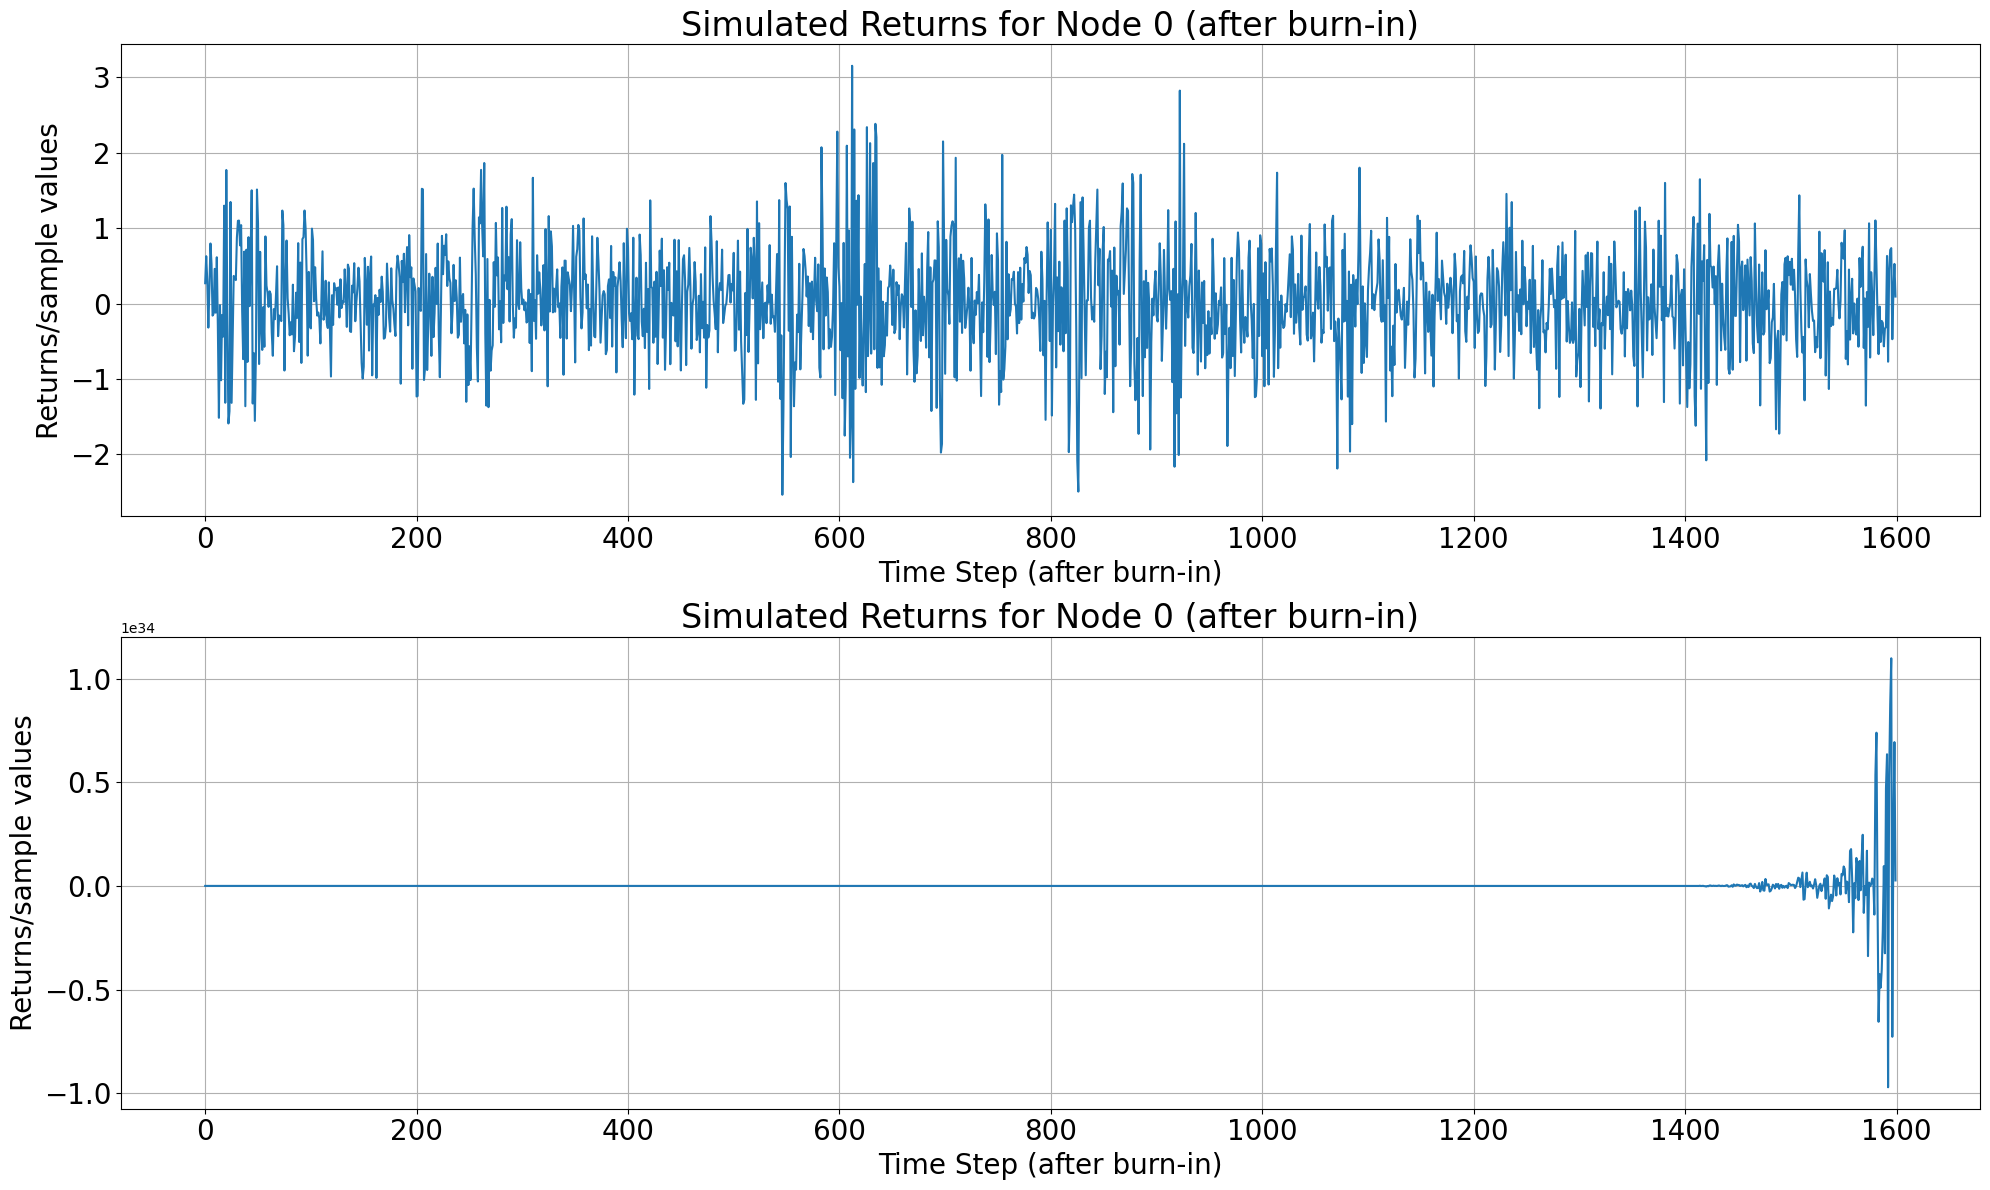

In [9]:
# Assume X_sim is (T, 5) and we discard the first 50 rows as burn‐in:
X_data = X_sim[burnin:, :]  # convergent samples
X_data_div = X_sim_div[burnin:, :]  # divergent samples

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 12))
axes[0].plot(X_data[:, 0])
axes[0].set_xlabel('Time Step (after burn-in)', fontsize=20)
axes[0].set_ylabel('Returns/sample values', fontsize=20)
axes[0].set_title('Simulated Returns for Node 0 (after burn-in)', fontsize=24)
axes[0].tick_params(axis='both', which='major', labelsize=20)
axes[0].grid()

axes[1].plot(X_data_div[:, 0])
axes[1].set_xlabel('Time Step (after burn-in)', fontsize=20)
axes[1].set_ylabel('Returns/sample values', fontsize=20)
axes[1].set_title('Simulated Returns for Node 0 (after burn-in)', fontsize=24)
axes[1].tick_params(axis='both', which='major', labelsize=20)
axes[1].grid()

plt.tight_layout()
plt.show()

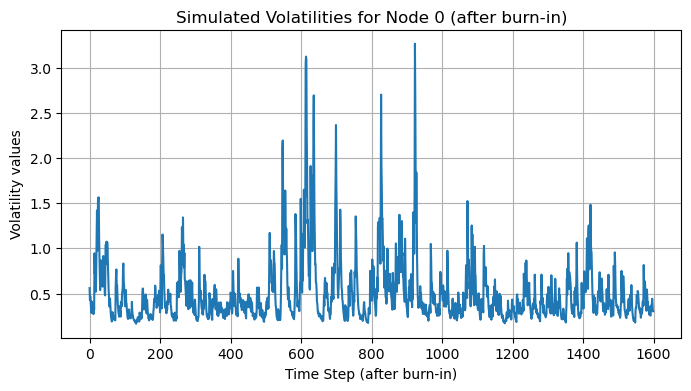

In [10]:
# Assume X_sim is (T, 5) and we discard the first 50 rows as burn‐in:
var_data = var_sim[burnin:, :]

plt.figure(figsize=(8, 4))
plt.plot(var_data[:, 0])
plt.xlabel('Time Step (after burn-in)')
plt.ylabel('Volatility values')
plt.title('Simulated Volatilities for Node 0 (after burn-in)')
plt.grid()
plt.show()

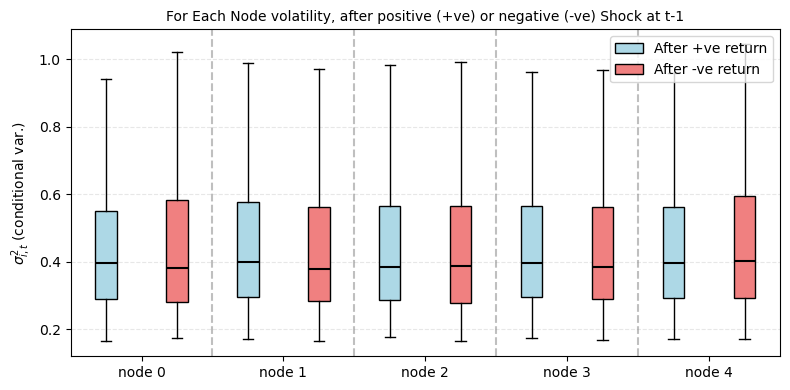

In [11]:
# Step 1: gather 'previous‐return signs' for each node i
# We want sign(X_data[t-1, i]) for t = 1,2,...,T_eff-1, where T_eff = T-burnin
# So we lose the first row of var_data (no previous return for t=0)
T_eff, d = X_data.shape

# Build a (T_eff-1) × d array of previous sign
prev_sign = np.sign(X_data[:-1, :])   # shape = (T_eff-1, d)
# Now var_data[1:, i] is the variance at t=1,...,T_eff-1 for node i,
# paired with prev_sign[t-1, i] = sign(X_data[t-1, i]).

# Step 2: for each node i, split node variances by whether prev_sign > 0 or < 0
pos_vars_by_node = []
neg_vars_by_node = []

for i in range(d):
    # mask arrays of length T_eff-1
    mask_positive = (prev_sign[:, i] >  0)
    mask_negative = (prev_sign[:, i] <  0)

    # collect node variances at times t=1,...,T_eff-1
    sigma2_i = var_data[1:, i]
    pos_vars_by_node.append( sigma2_i[mask_positive] )
    neg_vars_by_node.append( sigma2_i[mask_negative] )

# Step 3: build a side-by-side boxplot for each node
# We will create 2d arrays where boxplot expects a list of arrays, each array = data for one category. 
# So we want [pos_vars_node0, neg_vars_node0] for the first panel, then [pos_vars_node1, neg_vars_node1], etc.
data_to_plot = []
xticks = []
xlabels = []
for i in range(d):
    # Append positive group then negative group for node i
    data_to_plot.append(pos_vars_by_node[i])
    data_to_plot.append(neg_vars_by_node[i])
    xticks.append(2*i + 1.5)
    xlabels.append(f'node {i}')

plt.figure(figsize=(8, 4))
box = plt.boxplot(
    data_to_plot,
    widths=0.3,
    patch_artist=True,
    showfliers=False,
    medianprops={'color': 'black', 'linewidth': 1.5},
)

# Make positive boxes one colour, negative boxes a second colour
for i in range(d):
    pos_box = box['boxes'][2*i]
    neg_box = box['boxes'][2*i + 1]
    pos_box.set(facecolor='lightblue')
    neg_box.set(facecolor='lightcoral')

# Draw vertical separators between nodes for clarity
for i in range(d-1):
    plt.axvline(x=2*i + 2.5, color='gray', linestyle='--', alpha=0.5)

plt.xticks(xticks, xlabels, rotation=0)
plt.xlim(0.5, 2*d + 0.5)
plt.ylabel(r'$\sigma^2_{i,t}\;\text{(conditional var.)}$', fontsize=10)
plt.title('For Each Node volatility, after positive (+ve) or negative (-ve) Shock at t-1', fontsize=10)

# Create a custom legend for 'After positive' and 'After negative'
legend_handles = [
    Patch(facecolor='lightblue', edgecolor='k', label='After +ve return'),
    Patch(facecolor='lightcoral', edgecolor='k', label='After -ve return')
]
plt.legend(handles=legend_handles, loc='upper right')

plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

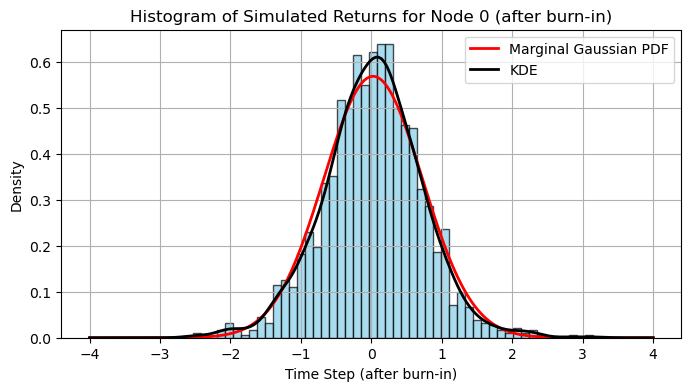

In [12]:
plt.figure(figsize=(8, 4))

# Generate a range of x values for the PDF and KDE
x = np.linspace(-4, 4, 200)

plt.hist(X_data[:, 0], bins=50, density=True, alpha=0.7, color='skyblue', edgecolor='black')
mu, sigma = np.mean(X_data[:, 0]), np.std(X_data[:, 0])
pdf_values = norm.pdf(x, mu, sigma)
kde = gaussian_kde(X_data[:, 0])
plt.plot(x, pdf_values, color='red', linewidth=2, label='Marginal Gaussian PDF')
plt.plot(x, kde(x), color='black', linewidth=2, label='KDE')
plt.title('Histogram of Simulated Returns for Node 0 (after burn-in)')
plt.xlabel('Time Step (after burn-in)')
plt.ylabel('Density')
plt.grid()
plt.legend()
plt.show()

In [13]:
# Kurtosis and skewness computation, to 3 decimal places
print(f'Kurtosis: {kurtosis(X_data[:, 0], fisher=False):.3f}')
print(f'Skewness: {skew(X_data[:, 0]):.3f}')

Kurtosis: 3.903
Skewness: 0.008


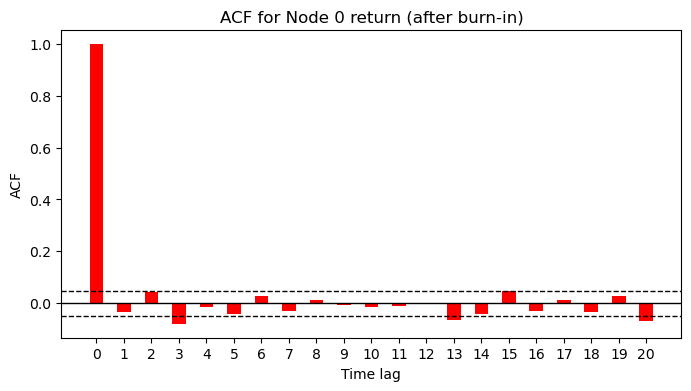

In [14]:
return_acfs = acf(X_data[:,0], nlags=20)
# critical band (interval)
ci = 1.96 / np.sqrt(len(X_data[:,0]))

plt.figure(figsize=(8, 4))
plt.bar(range(len(return_acfs)), return_acfs, width=0.5, color='r')
plt.axhline(0, color='k', linewidth=1.0)
plt.axhline(ci, linestyle='--', color='k', linewidth=1)
plt.axhline(-ci, linestyle='--', color='k', linewidth=1)
plt.xticks(np.arange(0, 21))
plt.xlabel('Time lag')
plt.ylabel('ACF')
plt.title('ACF for Node 0 return (after burn-in)')
plt.show()

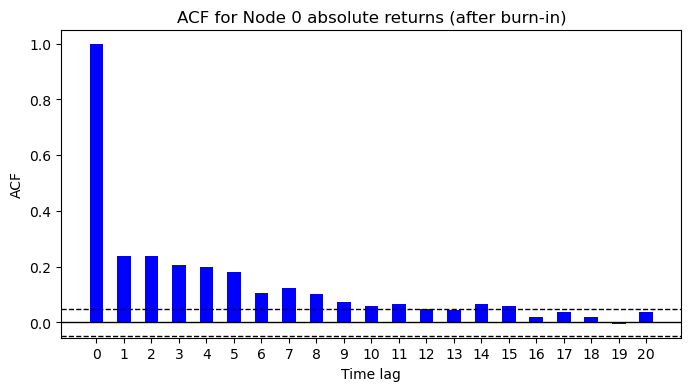

In [15]:
abs_return_acfs = acf(abs(X_data[:,0]), nlags=20)

plt.figure(figsize=(8, 4))
plt.bar(range(len(abs_return_acfs)), abs_return_acfs, width=0.5, color='b')
plt.axhline(0, color='k', linewidth=1.0)
plt.axhline(ci, linestyle='--', color='k', linewidth=1)
plt.axhline(-ci, linestyle='--', color='k', linewidth=1)
plt.xticks(np.arange(0, 21))
plt.xlabel('Time lag')
plt.ylabel('ACF')
plt.title('ACF for Node 0 absolute returns (after burn-in)')
plt.show()

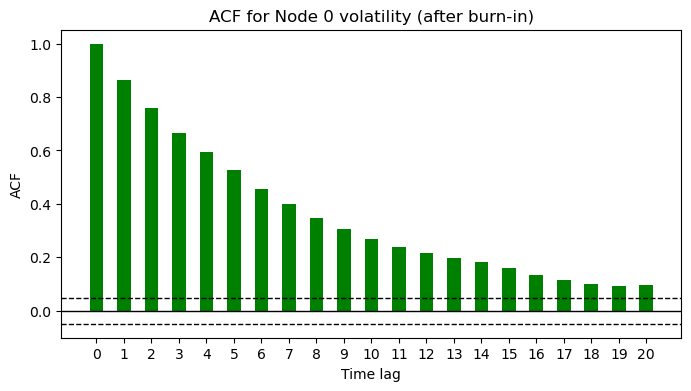

In [16]:
volatility_acfs = acf(np.sqrt(var_data[:,0]), nlags=20)
plt.figure(figsize=(8, 4))
plt.bar(range(len(volatility_acfs)), volatility_acfs, width=0.5, color='g')
plt.axhline(0, color='k', linewidth=1.0)
plt.axhline(ci, linestyle='--', color='k', linewidth=1)
plt.axhline(-ci, linestyle='--', color='k', linewidth=1)
plt.xticks(np.arange(0, 21))
plt.xlabel('Time lag')
plt.ylabel('ACF')
plt.title('ACF for Node 0 volatility (after burn-in)')
plt.show()

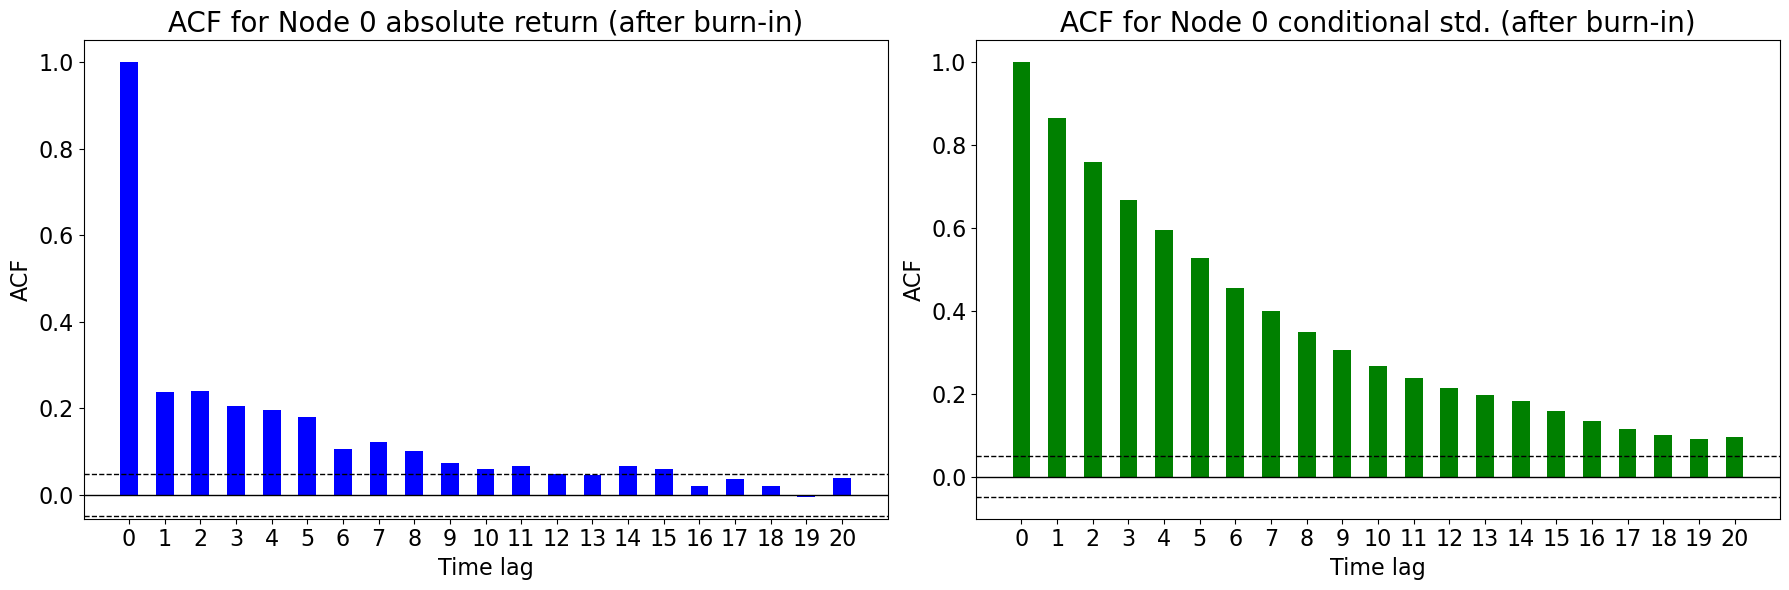

In [17]:
# (for thesis figures with larger size)
# For thesis using, a joint graph consisting all above three figures
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

axes[0].bar(range(len(abs_return_acfs)), abs_return_acfs, width=0.5, color='b')
axes[0].axhline(0, color='k', linewidth=1.0)
axes[0].axhline(ci, linestyle='--', color='k', linewidth=1)
axes[0].axhline(-ci, linestyle='--', color='k', linewidth=1)
axes[0].set_xticks(np.arange(0, 21))
axes[0].set_xlabel('Time lag', fontsize=16)
axes[0].set_ylabel('ACF', fontsize=16)
axes[0].set_title('ACF for Node 0 absolute return (after burn-in)', fontsize=20)
axes[0].tick_params(axis='both', which='major', labelsize=16)

axes[1].bar(range(len(volatility_acfs)), volatility_acfs, width=0.5, color='g')
axes[1].axhline(0, color='k', linewidth=1.0)
axes[1].axhline(ci, linestyle='--', color='k', linewidth=1)
axes[1].axhline(-ci, linestyle='--', color='k', linewidth=1)
axes[1].set_xticks(np.arange(0, 21))
axes[1].set_xlabel('Time lag', fontsize=16)
axes[1].set_ylabel('ACF', fontsize=16)
axes[1].set_title('ACF for Node 0 conditional std. (after burn-in)', fontsize=20)
axes[1].tick_params(axis='both', which='major', labelsize=16)

plt.tight_layout()
plt.show()

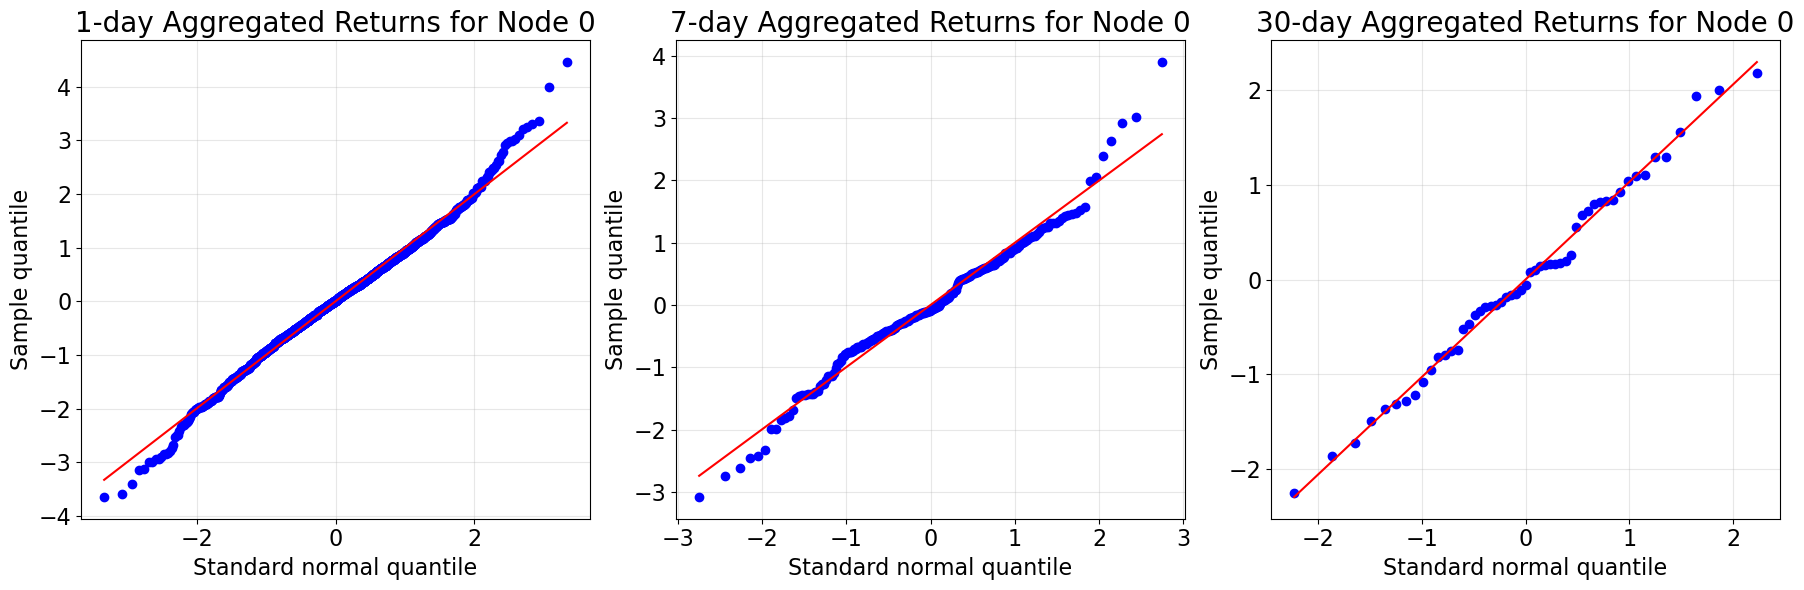

In [18]:
T, d = X_data.shape
h_values = [1, 7, 30]   # aggregation windows
series = X_data[:, 0]

fig, axes = plt.subplots(1, len(h_values), figsize=(18, 6))

for ax, h in zip(axes, h_values):
    # Aggregate returns
    n_blocks = T // h
    aggregated = np.array([series[j*h:(j+1)*h].sum() for j in range(n_blocks)])
    
    # Standardize to mean 0, variance 1
    agg_std = (aggregated - aggregated.mean()) / aggregated.std()
    
    # Draw QQ‐plot against N(0,1)
    probplot(agg_std, dist='norm', plot=ax)
    ax.get_lines()[1].set_color('red')
    ax.set_xlabel('Standard normal quantile', fontsize=16)
    ax.set_ylabel('Sample quantile', fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=16)
    
    ax.set_title(f'{h}-day Aggregated Returns for Node 0', fontsize=20)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

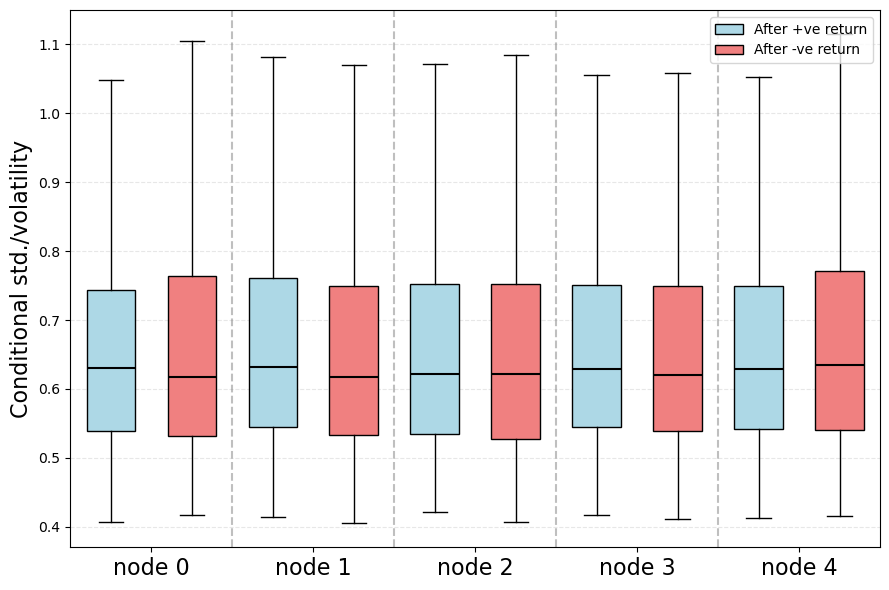

In [19]:
# (for thesis figures with larger size)
# Step 1: gather 'previous‐return signs' for each node i
# We want sign(X_data[t-1, i]) for t = 1,2,...,T_eff-1, where T_eff = T-burnin
# So we lose the first row of var_data (no previous return for t=0)
T_eff, d = X_data.shape

# Build a (T_eff-1) × d array of previous sign
prev_sign = np.sign(X_data[:-1, :])   # shape = (T_eff-1, d)
# Now var_data[1:, i] is the variance at t=1,...,T_eff-1 for node i,
# paired with prev_sign[t-1, i] = sign(X_data[t-1, i]).

# Step 2: for each node i, split node variances by whether prev_sign > 0 or < 0
pos_vars_by_node = []
neg_vars_by_node = []

for i in range(d):
    # mask arrays of length T_eff-1
    mask_positive = (prev_sign[:, i] >  0)
    mask_negative = (prev_sign[:, i] <  0)

    # collect node volatility at times t=1,...,T_eff-1
    sigma_i = np.sqrt(var_data[1:, i])
    pos_vars_by_node.append(sigma_i[mask_positive])
    neg_vars_by_node.append(sigma_i[mask_negative])

# Step 3: build a side-by-side boxplot for each node
# We will create 2d arrays where boxplot expects a list of arrays, each array = data for one category. 
# So we want [pos_vars_node0, neg_vars_node0] for the first panel, then [pos_vars_node1, neg_vars_node1], etc.
data_to_plot = []
xticks = []
xlabels = []
for i in range(d):
    # Append positive group then negative group for node i
    data_to_plot.append(pos_vars_by_node[i])
    data_to_plot.append(neg_vars_by_node[i])
    xticks.append(2*i + 1.5)
    xlabels.append(f'node {i}')

plt.figure(figsize=(9, 6))
box = plt.boxplot(
    data_to_plot,
    widths=0.6,
    patch_artist=True,
    showfliers=False,
    medianprops={'color': 'black', 'linewidth': 1.5},
)

# Make positive boxes one colour, negative boxes a second colour
for i in range(d):
    pos_box = box['boxes'][2*i]
    neg_box = box['boxes'][2*i + 1]
    pos_box.set(facecolor='lightblue')
    neg_box.set(facecolor='lightcoral')

# Draw vertical separators between nodes for clarity
for i in range(d-1):
    plt.axvline(x=2*i + 2.5, color='gray', linestyle='--', alpha=0.5)

plt.xticks(xticks, xlabels, rotation=0, fontsize=16)
plt.xlim(0.5, 2*d + 0.5)
plt.ylabel('Conditional std./volatility', fontsize=16)

# Create a custom legend for 'After positive' and 'After negative'
legend_handles = [
    Patch(facecolor='lightblue', edgecolor='k', label='After +ve return'),
    Patch(facecolor='lightcoral', edgecolor='k', label='After -ve return')
]
plt.legend(handles=legend_handles, loc='upper right')

plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

In [20]:
def nvacf_computation(series_data, W, S_list, max_lag, max_stage):
    """
    Compute and return the nvacf for a given time series X, 
    with a network of node weight matrix W and a list of r-stage adjacency matrices S_list.

    Args:
        series_data (np.ndarray): time series data of shape (T, d), T for number of time steps, d for number of nodes.
        W (np.ndarray): node weight matrix of shape (d, d).
        S_list (list): list of arrays as r-stage adjacency matrices, each of shape (d, d).
        max_lag (int): maximum lag to compute the nvacf for, i.e. lags = 1, ..., max_lag.
        max_stage (int): maximum stage to compute the nvacf for, i.e. stages = 1, ..., max_stage.
        
    Returns:
        nvacf (np.ndarray): computed nvacf of shape (max_lag, max_stage).
    """
    
    T, d = series_data.shape
    
    # Center the volatilities:
    mean_series_data = np.mean(series_data, axis=0)
    centered_series_data = series_data - mean_series_data
    
    # Compute the autocovariance upper bound lam
    lam = np.max(np.sqrt(np.sum((W * W), axis=0)))
    
    # Initialize the nvacf array
    nvacf = np.zeros((max_lag, max_stage))  # shape (max_lag, max_stage)
    
    if not isinstance(S_list, list):
        raise ValueError('S_list must be a list of r-stage adjacency matrices. '
                         'If you have only one stage, please provide a list with one element. '
                         'For example, S_list = [S1] for a single stage adjacency matrix S1.')
    if len(S_list) != max_stage:
        raise ValueError(f'S_list must contain {max_stage} r-stage adjacency matrices, but got {len(S_list)}.')
    
    # Iterate over each stage r = 1, ..., max_stage
    for r in range(1, max_stage + 1):
        # Use the corresponding r-stage adjacency to compute required matrices
        I = np.eye(d)
        M_num = W * S_list[r-1] + I  # shape (d, d), for the r-stage analysis
        M_denom = (1 + lam) * I  # shape (d, d)
        
        # Compute the numerator and denominator for each lag h = 1, ..., max_lag
        for h in range(1, max_lag + 1):
            # Numerator computation
            num = 0.0
            for t in range(0, T-h):
                v1 = centered_series_data[t+h, :]
                v0 = centered_series_data[t, :]
                num += v1.T @ M_num @ v0

            # Denominator computation
            denom = 0.0
            for t in range(0, T):
                v = centered_series_data[t, :]
                denom += v.T @ M_denom @ v

            # Compute and update the nvacf for this lag h and stage r
            nvacf[h-1, r-1] = num / denom
    
    return nvacf

In [21]:
S2_sim = np.array([
    [0, 0, 1, 0, 1],
    [0, 0, 0, 1, 0],
    [1, 0, 0, 0, 0],
    [0, 1, 0, 0, 1],
    [1, 0, 0, 1, 0]
])
S3_sim = np.zeros((5, 5))  # since our example network has no 3-stage neighbours, we set S3_sim to zero

nvacf = nvacf_computation(var_data, W_sim, [S1_sim, S2_sim, S3_sim], max_lag=20, max_stage=3)
nvacf

array([[0.69237593, 0.6993489 , 0.37211946],
       [0.58490215, 0.58958615, 0.31220179],
       [0.50741349, 0.50884896, 0.26826112],
       [0.45366528, 0.45177741, 0.23726341],
       [0.40037664, 0.3960331 , 0.20774399],
       [0.34106741, 0.33650676, 0.17593574],
       [0.30324537, 0.29901655, 0.15544667],
       [0.26993463, 0.26527915, 0.13754266],
       [0.24014021, 0.23530892, 0.12188015],
       [0.21508216, 0.21050842, 0.1084473 ],
       [0.19295406, 0.18886313, 0.09672967],
       [0.17385927, 0.17085495, 0.08674129],
       [0.15529769, 0.15300861, 0.0776798 ],
       [0.1394493 , 0.13809397, 0.07023172],
       [0.11726438, 0.11634781, 0.0593481 ],
       [0.09548596, 0.09369296, 0.04801793],
       [0.08108242, 0.07844787, 0.04052309],
       [0.06472264, 0.06116607, 0.0317511 ],
       [0.05397699, 0.0498585 , 0.0260361 ],
       [0.0509635 , 0.04638078, 0.02408167]])

In [22]:
def Corbit_plot(nvacf):
    """
    Plot the Corbit plot for the given nvacf.

    Args:
        nvacf (np.ndarray): computed nvacf of shape (max_lag, max_stage).
    """
    
    max_lag, max_stage = nvacf.shape  # shape = (max_lag, max_stage)

    # Angles for each lag h = 1, ..., max_lag
    theta_per_lag = np.linspace(0, 2*np.pi, max_lag, endpoint=False)  # shape (max_lag,)

    # Radii for each stage r = 1, ..., max_stage
    radii = np.arange(1, max_stage+1)  # shape (max_stage,)

    # Form two 1D arrays `thetas` and `rhos`, each of length (max_lag*max_stage),
    # thetas should be in the form of [theta_1, theta_1, ..., theta_1, theta_2, ..., theta_max_lag], 
    # where each angle theta_h is repeated max_stage times for each lag h
    # On the other hand, rhos should be in the form of [1, 2, ..., max_stage, 1, 2, ..., max_stage, ..., 1, 2, ..., max_stage],
    # where each set of radius/distance [1, 2, ..., max_stage] is repeated max_lag times for each stage r

    # Using of thetas and rhos can help us to plot the nvacf values in a polar scatter plot in the order of
    # [(h=1,r=1), (h=2,r=1), …, (h=max_lag, r=1), (h=1, r=2), ..., (h=max_lag, r=max_stage)]
    thetas = np.repeat(theta_per_lag, max_stage)
    rhos = np.tile(radii, max_lag)
    
    # Flatten the nvacf values into a 1D array `values`, in the same ordering
    nvacf_values = []
    for h in range(1, max_lag+1):
        for r in range(1, max_stage+1):
            nvacf_values.append(nvacf[h-1, r-1])
    nvacf_values = np.array(nvacf_values)   # shape = (max_lag * max_stage,)

    # Create a polar‐scatter Corbit with color = nvacf value, size = |nvacf| * 500
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(projection='polar')

    # Remove the default polar frame circle
    ax.spines['polar'].set_visible(False)
    
    # Choose a colormap and a normalisation so that we can map nvacf to colors 
    cmap = colormaps['viridis']
    vmin = np.min(nvacf_values)
    vmax = np.max(nvacf_values)

    # Compute and scale a reasonable size for each point. Larger nvacf would result in larger dots
    sizes = (np.abs(nvacf_values) * max_lag * 5)

    # Create the polar-scatter
    scatter = ax.scatter(thetas, rhos, c=nvacf_values, s=sizes, cmap=cmap, vmin=vmin, vmax=vmax)

    # Draw a circle at each integer radius for clarity
    for r in radii:
        ax.plot(np.linspace(0, 2*np.pi, 400), [r]*400, color='gray', lw=0.5, ls='--', alpha=0.5)

    # Label each ring by its stage, outside the ring
    for r in radii:
        ax.text(0, r + 0.05, f'Stage {r}', color='black', fontsize=10, ha='left', va='bottom')

    # Label each angular position by its lag index, outside the outermost ring
    outer_radius = radii.max() + 1.0
    for i, h in enumerate(range(1, max_lag+1)):
        angle = theta_per_lag[i]
        ax.text(angle, outer_radius, str(h), fontsize=10, ha='center', va='center')

    # Tidy up the polar axes
    ax.set_ylim(0, outer_radius + 0.5)  # set the radial limits
    ax.set_yticks([])  # hide the radial tick labels
    ax.set_xticks([])  # hide the angular tick labels
    ax.set_title(f'GNGARCH nvacf (lags 1 to {max_lag}, stages 1 to {max_stage}) Corbit plot', 
                 fontsize=16)

    # Add a colorbar at the side
    cbar = plt.colorbar(scatter, pad=0.1, fraction=0.05, shrink=0.6)
    cbar.set_label('nvacf value', rotation=270, labelpad=20, fontsize=12, loc='center')

    plt.tight_layout()
    plt.show()

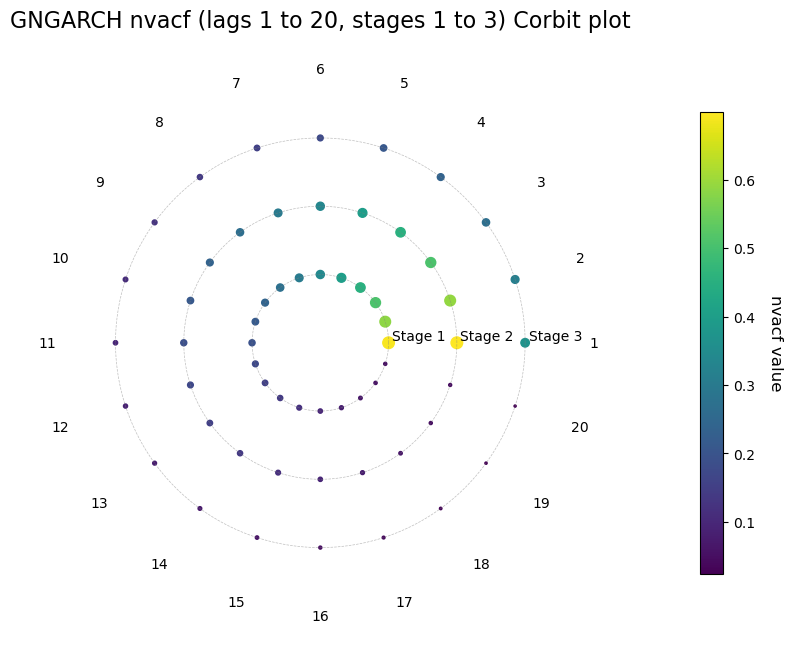

In [23]:
Corbit_plot(nvacf)

### Parameter fitting

In [24]:
class GNGARCH(nn.Module):
    def __init__(self, d, W, S, device, init_params=None):
        super().__init__()
        self.d = d
        self.device = device
        
        # Compute W_s and create neighbour mask
        W_s = W * S
        self.register_buffer('W_s', W_s)
        
        # Initialise trainable log-parameters
        if init_params is None:
            init_vals = torch.tensor([0.1, 0.3, 0.4, 0.1, 0.1], 
                                    dtype=torch.float32, device=device)
            init_params = torch.log(init_vals)
        self.params = nn.Parameter(init_params)

    def get_params(self):
        """Return constrained (positive) parameters"""
        alpha0, alpha1, gamma1, beta11, delta11 = torch.exp(self.params)
        return alpha0, alpha1, gamma1, beta11, delta11
    
    @staticmethod
    def compute_B_t(X_t):
        """Compute and return matrix B_t, PyTorch version."""
        B_t = torch.outer(X_t, X_t)
        B_t.fill_diagonal_(0.0)  # we can directly use fill_diagonal_ in PyTorch when it is just a number
        return B_t
    
    @staticmethod
    def compute_D_t(cov_t):
        """Compute and return matrix D_t, PyTorch version."""
        D_t = cov_t.clone()
        D_t.fill_diagonal_(0.0)
        return D_t

    def compute_conditional(self, X_prev, var_prev, cov_prev):
        """Vectorized computation with proper exclusions"""
        alpha0, alpha1, gamma1, beta11, delta11 = self.get_params()
        d = self.d
        
        # 1. Vectorised variance update
        clustering_term = beta11 * (self.W_s @ (X_prev ** 2))
        persistence_term = delta11 * (self.W_s @ var_prev)
        var_curr = alpha0 + alpha1 * (X_prev ** 2) + gamma1 * var_prev + clustering_term + persistence_term
        
        # 2. Vectorised covariance update
        # Base GARCH component
        base_cov = alpha0 + alpha1 * torch.outer(X_prev, X_prev) + gamma1 * cov_prev
        
        # Neighbouring clustering effect using vectorisation
        compute_B_prev = self.compute_B_t(X_prev)
        clustering_i_neighbour = self.W_s @ compute_B_prev
        clustering_j_neighbour = compute_B_prev @ self.W_s.T
        clustering_neighbour = 0.5 * beta11 * (clustering_i_neighbour + clustering_j_neighbour)
        
        # Neighbouring persistence effect using vectorisation
        compute_D_prev = self.compute_D_t(cov_prev)
        persistence_i_neighbour = self.W_s @ compute_D_prev
        persistence_j_neighbour = compute_D_prev @ self.W_s.T
        persistence_neighbour = 0.5 * delta11 * (persistence_i_neighbour + persistence_j_neighbour)
        
        # Combine components, both based part and neighbouring part
        cov_curr = base_cov + clustering_neighbour + persistence_neighbour
        cov_curr[range(d), range(d)] = var_curr  # Set diagonal
        
        return var_curr, cov_curr
    
    def ensure_posdef_cholesky(self, cov_mat):
        """
        Ensure covariance matrix is positive definite and not ill-conditioned by adding jitter, 
        so we can use Cholesky decomposition.
        """
        # Compute the eigenvalues and check if the matrix is positive definite
        min_eigval = torch.min(torch.linalg.eigvalsh(cov_mat))
        jitter = torch.zeros_like(cov_mat)  # initialise jitter to zero
        # Set a threshold for jitter, ensuring PD and not ill-conditioned 
        # this value is normally 1e-3 or 1e-4, as even smaller thresholds may lead slow convergence (still ill-conditioned)
        # a big threshold may perturb the covariance matrix too much
        threshold = 1e-3
        # If the minimum eigenvalue is less than threshold, we need to add jitter to ensure PD
        if min_eigval < threshold:
            jitter = (-min_eigval + threshold) * torch.eye(self.d, device=self.device)
            
        L = torch.linalg.cholesky(cov_mat + jitter)
        return L
    
    def nll_loss(self, X_data, var0, cov0):
        """
        Compute the negative Log-Likelihood loss (MLE/QMLE),
        Assumes conditional multivariate normal distribution.
        """
        T, d = X_data.shape
        total_nll = 0.0

        var_prev, cov_prev = var0.clone(), cov0.clone()
        const = d * torch.log(2 * torch.tensor(torch.pi, device=self.device))

        for t in range(1, T):
            X_prev, X_curr = X_data[t-1], X_data[t]
            var_curr, cov_curr = self.compute_conditional(X_prev, var_prev, cov_prev)
            L = self.ensure_posdef_cholesky(cov_curr)

            # Compute the log-determinant term using Cholesky decomposition L
            log_det = 2.0 * torch.sum(torch.log(torch.diag(L)))
            
            # Compute the quadratic form: X_curr^T * inv(Sigma) * X_curr
            inv_cov_curr = torch.cholesky_inverse(L)
            quad = X_curr @ (inv_cov_curr @ X_curr)
            total_nll += 0.5 * (const + log_det + quad)
            
            # Update previous values for next iteration
            var_prev, cov_prev = var_curr, cov_curr

        return total_nll / (T - 1)
    
    # An alternative loss function that computes the MSE
    def mse_loss(self, X_data, var0, cov0):
        """
        Vectorized MSE loss computation, comparing conditional covariance with observed squared returns.
        """
        T, d = X_data.shape
        total_mse = 0.0
        var_prev = var0.clone()
        cov_prev = cov0.clone()
        
        for t in range(1, T):
            X_prev = X_data[t-1]
            var_curr, cov_curr = self.compute_conditional(X_prev, var_prev, cov_prev)
            # Compute observed covariance proxy
            obs_cov = torch.outer(X_data[t], X_data[t])
            # Vectorised MSE
            total_mse += torch.mean((cov_curr - obs_cov) ** 2)
            
            # Update state
            var_prev = var_curr
            cov_prev = cov_curr
        return total_mse / (T - 1)
    
    def forward(self, X_data, var0, cov0):
        T, d = X_data.shape
        X_sim = torch.zeros_like(X_data)
        var_prev = var0.clone()
        cov_prev = cov0.clone()
        X_sim[0] = X_data[0]
        
        for t in range(1, T):
            X_prev = X_data[t-1]
            var_curr, cov_curr = self.compute_conditional(X_prev, var_prev, cov_prev)
            L = self.ensure_posdef_cholesky(cov_curr)
            
            Z = torch.randn(d, device=self.device)
            X_sim[t] = L @ Z
            # Update the previous values for the next iteration
            var_prev = var_curr
            cov_prev = cov_curr
        return X_sim

In [25]:
# Prepare the data & network
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
GNGARCH_data_torch = torch.tensor(X_data, dtype=torch.float32).to(device)  # load the simulated X_data, shape (T, d)
T, d = GNGARCH_data_torch.shape
W_sim_torch = torch.tensor(W_sim, dtype=torch.float32).to(device)  # shape (d, d)
S1_sim_torch = torch.tensor(S1_sim, dtype=torch.float32).to(device)  # shape (d, d)

# Initial states var0 and cov0
var0 = torch.ones(d, dtype=torch.float32).to(device)  # initial variances
cov0 = torch.eye(d, dtype=torch.float32).to(device)  # initial covariances (identity matrix)

# Instantiate model + optimizer
model = GNGARCH(d=d, W=W_sim_torch, S=S1_sim_torch, device=device).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [26]:
# Model training and parameter fitting
def train(n_epochs, model, data, var0, cov0, method, optimizer):
    loss_history = []
    for epoch in range(1, n_epochs+1):
        optimizer.zero_grad()
        if method == 'nll':
            loss = model.nll_loss(data, var0, cov0)
        elif method == 'mse':
            loss = model.mse_loss(data, var0, cov0)
        else:
            raise ValueError('Method must be either nll or mse.')
        # Store the loss for plotting
        loss_history.append(loss.item())
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print(f'Epoch {epoch}: {method} loss = {loss.item():.4f}')
            
    # Extract fitted parameters
    with torch.no_grad():
        alpha0, alpha1, gamma1, beta11, delta11 = model.get_params()
    print(f'Fitted parameters via {method}:')
    print(f'alpha0 = {alpha0.item():.4f}')
    print(f'alpha1 = {alpha1.item():.4f}')
    print(f'gamma1 = {gamma1.item():.4f}')
    print(f'beta11 = {beta11.item():.4f}')
    print(f'delta11 = {delta11.item():.4f}')
    
    return loss_history

In [27]:
# Train the model with both mse and nll methods (total 20 min on PC)
mse_loss_history = train(n_epochs=500, model=model, data=GNGARCH_data_torch, var0=var0, cov0=cov0, 
                         method='mse', optimizer=optimizer)
nll_loss_history = train(n_epochs=500, model=model, data=GNGARCH_data_torch, var0=var0, cov0=cov0, 
                         method='nll', optimizer=optimizer)

Epoch 100: mse loss = 0.5212
Epoch 200: mse loss = 0.5193
Epoch 300: mse loss = 0.5186
Epoch 400: mse loss = 0.5184
Epoch 500: mse loss = 0.5184
Fitted parameters via mse:
alpha0 = 0.0627
alpha1 = 0.1601
gamma1 = 0.5926
beta11 = 0.0291
delta11 = 0.0864
Epoch 100: nll loss = 7.1675
Epoch 200: nll loss = 7.1676
Epoch 300: nll loss = 7.1675
Epoch 400: nll loss = 7.1674
Epoch 500: nll loss = 7.1676
Fitted parameters via nll:
alpha0 = 0.0481
alpha1 = 0.1633
gamma1 = 0.6200
beta11 = 0.0461
delta11 = 0.0428


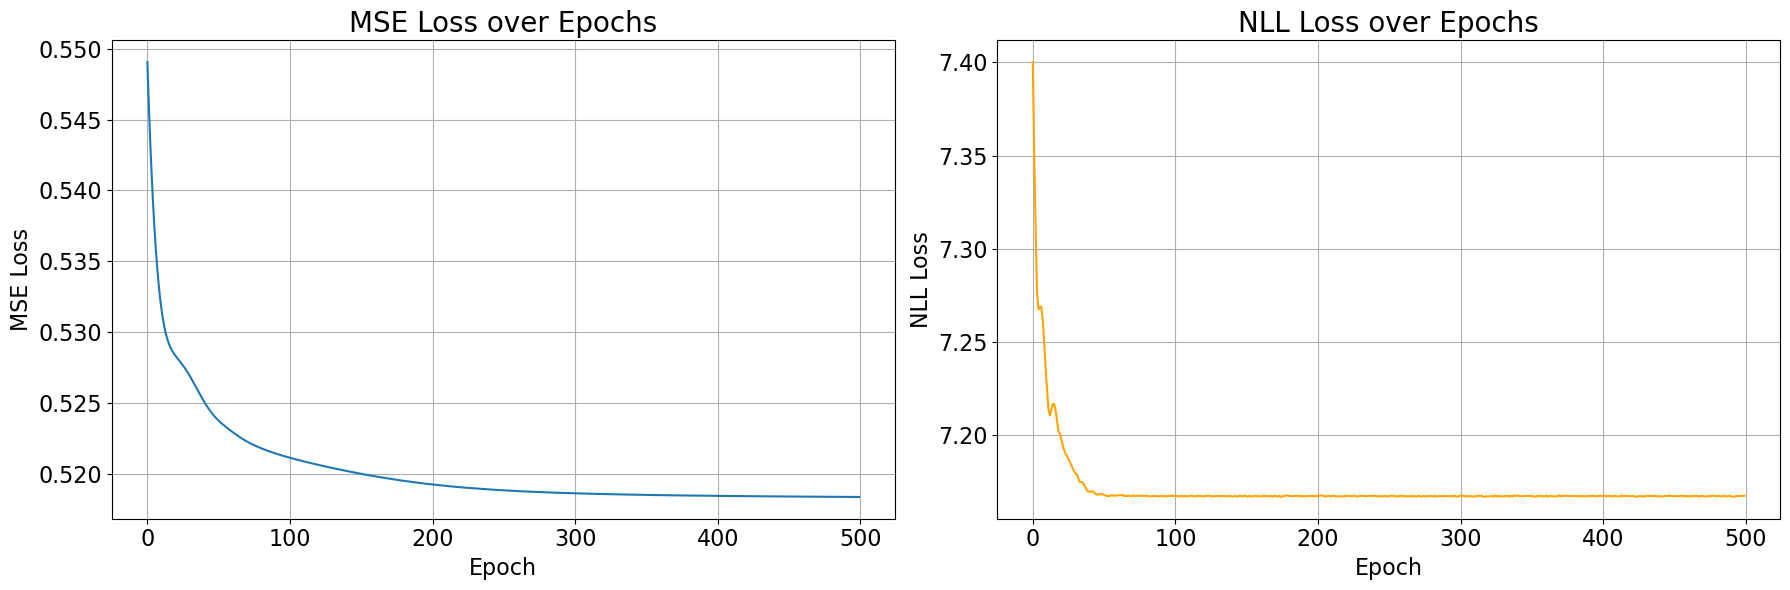

In [28]:
# Plot the training loss history for showing convergence

# Create 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# MSE loss convergence
axes[0].plot(mse_loss_history, label='MSE Loss')
axes[0].set_xlabel('Epoch', fontsize=16)
axes[0].set_ylabel('MSE Loss', fontsize=16)
axes[0].set_title('MSE Loss over Epochs', fontsize=20)
axes[0].tick_params(axis='both', which='major', labelsize=16)
axes[0].grid()

# NLL loss convergence
axes[1].plot(nll_loss_history, label='NLL Loss', color='orange')
axes[1].set_xlabel('Epoch', fontsize=16)
axes[1].set_ylabel('NLL Loss', fontsize=16)
axes[1].set_title('NLL Loss over Epochs', fontsize=20)
axes[1].tick_params(axis='both', which='major', labelsize=16)
axes[1].grid()

plt.tight_layout()
plt.show()

In [29]:
def train_different_seed(n_epochs, model, data, var0, cov0, method, optimizer):
    loss_history = []
    for epoch in range(1, n_epochs+1):
        optimizer.zero_grad()
        if method == 'nll':
            loss = model.nll_loss(data, var0, cov0)
        elif method == 'mse':
            loss = model.mse_loss(data, var0, cov0)
        else:
            raise ValueError('Method must be either nll or mse.')
        # Store the loss for plotting
        loss_history.append(loss.item())
        loss.backward()
        optimizer.step()
            
    # Extract fitted parameters
    with torch.no_grad():
        alpha0, alpha1, gamma1, beta11, delta11 = model.get_params()
    
    return loss_history, alpha0, alpha1, gamma1, beta11, delta11

### Multiple simulation data and parameter fitting summary

In [ ]:
# Initialise the parameter list for storing fitted results
alpha0_arr = np.zeros((20, 2))
alpha1_arr = np.zeros((20, 2))
gamma1_arr = np.zeros((20, 2))
beta11_arr = np.zeros((20, 2))
delta11_arr = np.zeros((20, 2))

T = 2000

# Simulate with a set of different seeds (20 seeds for 95-100 min...)
for seed in range(20):
    # Initial values (np. form)
    X0 = np.zeros(d)  # start with zero returns
    var0 = np.ones(d)  # small initial variance
    cov0 = np.eye(d)  # small positive definite covariance
    X_sim, var_sim, cov_sim = network_GARCH_simulation(
        W_sim, S1_sim, params_example, T, X0, var0, cov0, seed=seed
    )
    burnin = int(T * 0.2)
    X_data = X_sim[burnin:, :]

    # Prepare the data & network
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    GNGARCH_data_torch = torch.tensor(X_data, dtype=torch.float32).to(device)  # load the simulated X_data, shape (T, d)
    T, d = GNGARCH_data_torch.shape
    W_sim_torch = torch.tensor(W_sim, dtype=torch.float32).to(device)  # shape (d, d)
    S1_sim_torch = torch.tensor(S1_sim, dtype=torch.float32).to(device)  # shape (d, d)

    # Initial states
    var0 = torch.ones(d, dtype=torch.float32).to(device)  # initial variances
    cov0 = torch.eye(d, dtype=torch.float32).to(device)  # initial covariances (identity matrix)

    # Instantiate model + optimizer
    model = GNGARCH(d=d, W=W_sim_torch, S=S1_sim_torch, device=device).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    mse_loss_history, alpha0_mse, alpha1_mse, gamma1_mse, beta11_mse, delta11_mse = train_different_seed(n_epochs=500, 
                                                                                                         model=model, data=GNGARCH_data_torch, 
                                                                                                         var0=var0, cov0=cov0, 
                                                                                                         method='mse', optimizer=optimizer)
    nll_loss_history, alpha0_nll, alpha1_nll, gamma1_nll, beta11_nll, delta11_nll = train_different_seed(n_epochs=500, 
                                                                                                         model=model, data=GNGARCH_data_torch, 
                                                                                                         var0=var0, cov0=cov0, 
                                                                                                         method='nll', optimizer=optimizer)
    # Update values
    alpha0_arr[seed, :] = [alpha0_mse, alpha0_nll]
    alpha1_arr[seed, :] = [alpha1_mse, alpha1_nll]
    gamma1_arr[seed, :] = [gamma1_mse, gamma1_nll]
    beta11_arr[seed, :] = [beta11_mse, beta11_nll]
    delta11_arr[seed, :] = [delta11_mse, delta11_nll]    

C:\Users\Brian\AppData\Local\Temp\ipykernel_49468\3669884022.py:126: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  X_sim[t, :] = np.random.multivariate_normal(mean=np.zeros(d), cov=new_cov)


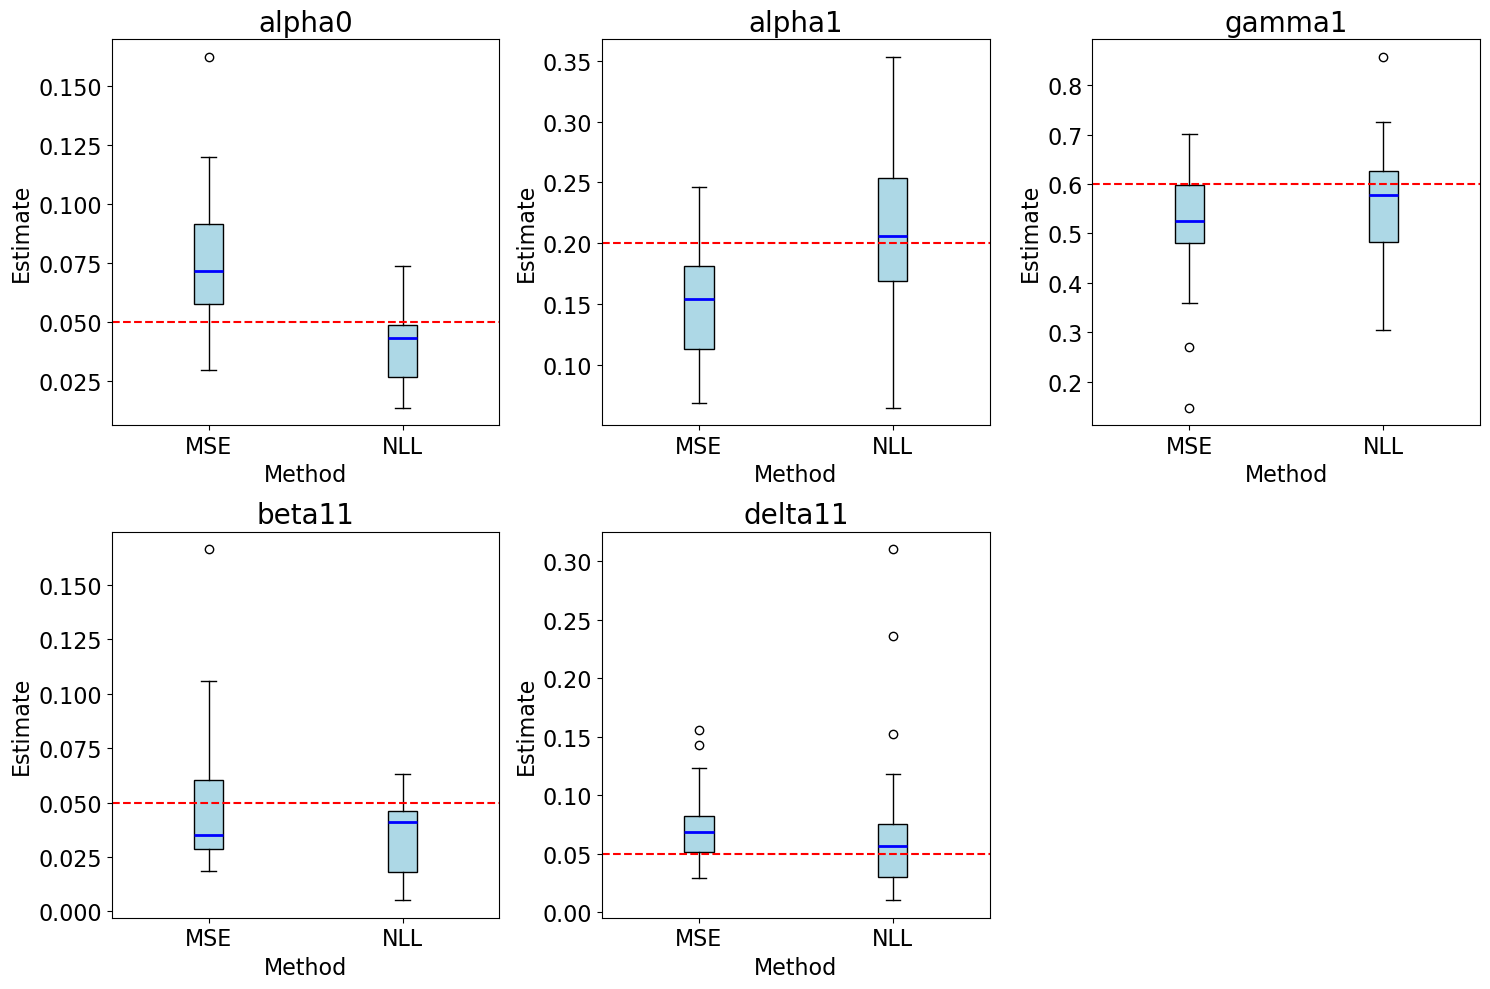

In [31]:
# Combine into a list
param_data = [alpha0_arr, alpha1_arr, gamma1_arr, beta11_arr, delta11_arr]
param_names = ['alpha0', 'alpha1', 'gamma1', 'beta11', 'delta11']
methods = ['MSE', 'NLL']
true_vals = [0.05, 0.20, 0.60, 0.05, 0.05]  # true values for the parameters

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, (ax, data, name, true_val) in enumerate(zip(axes, param_data, param_names, true_vals)):
    # boxplot
    bp = ax.boxplot(data, labels=methods, patch_artist=True,
                    boxprops=dict(facecolor='lightblue', edgecolor='black'),
                    medianprops=dict(color='blue', linewidth=2))
    
    # true‐value line
    ax.axhline(true_val, color='red', linestyle='--')
    # titles and labels
    ax.set_title(name, fontsize=20)
    ax.set_xlabel('Method', fontsize=16)
    ax.set_ylabel('Estimate', fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=16)

# Turn off the unused subplot
axes[-1].axis('off')

plt.tight_layout()
plt.show()

In [32]:
print(alpha0_arr.mean(axis=0), alpha0_arr.std(axis=0))
print(alpha1_arr.mean(axis=0), alpha1_arr.std(axis=0))
print(gamma1_arr.mean(axis=0), gamma1_arr.std(axis=0))
print(beta11_arr.mean(axis=0), beta11_arr.std(axis=0))
print(delta11_arr.mean(axis=0), delta11_arr.std(axis=0))

[0.07784322 0.0425506 ] [0.02973733 0.01690797]
[0.14856405 0.2093078 ] [0.0472568  0.07494625]
[0.51169561 0.56277883] [0.12622155 0.1301244 ]
[0.04881577 0.03464682] [0.0352279  0.01696389]
[0.07426744 0.07722971] [0.03379652 0.07447272]


### GTN-GNGARCH

In [33]:
def GTN_GARCH_simulation(W, S, params, T, X0, var0, cov0, seed=0):
    """
    Simulate a GTN-GARCH (global GTN-GARCH(1,1,[1],[1])) over T time steps for a network with d nodes.

    Args:
        W (np.ndarray): node weight matrix of shape (d, d), where d is the number of nodes.
        S (np.ndarray): r-stage adjacency matrix of shape (d, d), where d is the number of nodes.
        params (dict): dictionary containing GNGARCH parameters:
            alpha0: positive float
            alpha1_pos: non-negative float
            alpha1_neg: non-negative float
            alpha1_inter: non-negative float
            gamma1: non-negative float
            beta11: non-negative float
            delta11: non-negative float
        T (int): total number of time steps to simulate, for t = 0, 1, ..., T-1.
        X0 (np.ndarray): initial returns at time t=0 along with d nodes, i.e. (X_{1,0}, X_{2,0}, ..., X_{d,0}).
        var0 (np.ndarray): initial conditional variances at t=0, i.e. (sigma2_{1,0}, sigma2_{2,0}, ..., sigma2_{d,0}).
        cov0 (np.ndarray): Initial conditional covariances at t=0, i.e. sigma_{ij,0}, include the diagonal variances, so of shape (d, d).
        seed: control the randomness, default 0.
    
    Returns:
        X_sim (np.ndarray): simulated returns of shape (T, d).
        var_sim (np.ndarray): simulated conditional variances of shape (T, d).
        cov_sim (np.ndarray): simulated conditional covariances of shape (T, d, d), include the diagonal variances.
    """

    np.random.seed(seed)
    
    # Unpack parameters from the dictionary
    alpha0  = params['alpha0']
    alpha1_pos  = params['alpha1_pos']
    alpha1_neg  = params['alpha1_neg']
    alpha1_inter  = params['alpha1_inter']
    gamma1  = params['gamma1']
    beta11  = params['beta11']
    delta11 = params['delta11']
    
    # Dimensionality check, based on the number of nodes
    d = W.shape[0]
    # Validate input shapes
    assert W.shape == (d, d), 'W must be an (d,d) matrix'
    assert X0.shape == (d,)
    assert var0.shape == (d,)
    assert cov0.shape == (d, d)
    
    # Initialise arrays to hold the simulated values
    X_sim = np.zeros((T, d))  # each row is value for all d nodes at a time step
    var_sim = np.zeros((T, d))  # each row is the conditional variance/volatility for all d nodes at a time step
    cov_sim = np.zeros((T, d, d))  # each element is the conditional covariance matrix for all d nodes at a time step, diagonal entries replaced by variances
    # Assert initial values.
    X_sim[0, :] = X0.copy()
    var_sim[0, :] = var0.copy()
    cov_sim[0, :, :] = cov0.copy()

    # Precompute 1-stage neighbour lists
    # This can be done by using the Hadamard product of W and S, denoted as W_s
    W_s = W * S
    neighbours = [np.where(W_s[i, :] != 0)[0] for i in range(d)]  # list of arrays, each containing the indices of the 1-stage neighbours for each node
    
    # Iteration over time steps for simulation from t=1 to T-1
    for t in range(1, T):
        X_prev = X_sim[t-1, :]  # previous returns (for all nodes) at time t-1
        var_prev = var_sim[t-1, :]  # revious conditional variances (for all nodes) at time t-1
        cov_prev = cov_sim[t-1, :, :]  # previous conditional covariances (for all nodes) at time t-1

        # Step 1: Update each node's conditional variance via model definition
        # We can vectorize the neighbour sums via matrix multiplication
        clustering_term = beta11 * (W_s @ (X_prev**2))
        persistence_term = delta11 * (W_s @ var_prev)
        # Examine the sign of X_prev to determine the appropriate alpha1 value
        alpha1_prime = np.where(X_prev >= 0, alpha1_pos, alpha1_neg)  # choose alpha1 based on the sign of X_prev
        # Update the conditional variance for each node
        var_sim[t, :] = alpha0 + alpha1_prime * (X_prev**2) + gamma1 * var_prev + clustering_term + persistence_term

        # Step 2: Update the full conditional covariance matrix by computing each off-diagonal covariance entry
        # Due to symmetry, we only need to compute for i < j and apply the symmetry
        new_cov = np.zeros((d, d))  # initialise the new covariance matrix for replacement
        for i in range(d):
            for j in range(i + 1, d):
                
                # Condition masks for the current pair (i, j)
                if np.minimum(X_prev[i], X_prev[j]) >= 0:
                    # Both X_prev[i] and X_prev[j] are non-negative
                    alpha1_double_prime = alpha1_pos
                elif np.maximum(X_prev[i], X_prev[j]) < 0:
                    # Both X_prev[i] and X_prev[j] are negative
                    alpha1_double_prime = alpha1_neg
                else:
                    # One is non-negative and the other is negative
                    alpha1_double_prime = alpha1_inter
                
                # GARCH‐type part for (i,j)
                base_ij = (
                    alpha0
                    + alpha1_double_prime * (X_prev[i] * X_prev[j])
                    + gamma1 * cov_prev[i, j]
                )

                # Neighbouring clustering effect on covariance:
                # we should both consider the neighbouring nodes of i and j
                sum_i_neighbours_clustering = 0.0
                for u in neighbours[i]:
                    if u == j:  # skip if u is j
                        continue
                    sum_i_neighbours_clustering += W_s[i, u] * X_prev[u] * X_prev[j]
                sum_j_neighbours_clustering = 0.0
                for v in neighbours[j]:
                    if v == i:  # skip if v is i
                        continue
                    sum_j_neighbours_clustering += W_s[j, v] * X_prev[i] * X_prev[v]
                clustering_ij = 0.5 * beta11 * (sum_i_neighbours_clustering + sum_j_neighbours_clustering)

                # Neighbouring persistence effect on covariance:
                # again consider both the neighbouring nodes of i and j
                sum_i_neighbours_persistence = 0.0
                for u in neighbours[i]:
                    if u == j:  # skip if u is j
                        continue
                    sum_i_neighbours_persistence += W_s[i, u] * cov_prev[u, j]
                sum_j_neighbours_persistence = 0.0
                for v in neighbours[j]:
                    if v == i:  # skip if v is i
                        continue
                    sum_j_neighbours_persistence += W_s[j, v] * cov_prev[i, v]
                persistence_ij = 0.5 * delta11 * (sum_i_neighbours_persistence + sum_j_neighbours_persistence)

                # Combine all parts to form the new covariance entry
                new_cov[i, j] = base_ij + clustering_ij + persistence_ij
                # Enforce symmetry
                new_cov[j, i] = new_cov[i, j]

        # Step 3: We need to replace/insert the diagonal entries with conditional variances computed
        for i in range(d):
            new_cov[i, i] = var_sim[t, i]
        # Update the covariance matrix for this time step
        cov_sim[t, :, :] = new_cov

        # Final simulation step on X_sim: draw X_t|F_{t-1} ~ N(0, Sigma_t), under Gaussian assumption
        # we assume Z_{i,t} ~ N(0, 1) being iid, as strong white noise, so this ensures the conditional independence
        # Empirically, we need to ensure that the covariance matrix (new_cov) is positive definite
        # without rigorous analytical proofs, it is common to add a tiny jitter to the diagonal if it is near‐singular
        try:
            X_sim[t, :] = np.random.multivariate_normal(mean=np.zeros(d), cov=new_cov)
        except np.linalg.LinAlgError:
            # If the covariance matrix is not positive definite, cov_nearest is used to find the nearest positive definite matrix
            # without changing the diagonal variance entries
            cov_jittered = cov_nearest(new_cov, method='nearest', threshold=1e-15)
            X_sim[t, :] = np.random.multivariate_normal(mean=np.zeros(d), cov=cov_jittered)

    return X_sim, var_sim, cov_sim

In [34]:
d = 5  # for our example we have 5 nodes

# Initial values (t = 0)
X0 = np.zeros(d)  # start with zero returns
var0 = np.ones(d)  # small initial variance
cov0 = np.eye(d)  # small positive definite covariance
T = 2000
burnin = int(T * 0.2)

# Choose some initial GTN-GARCH(1,1,[1],[1]) parameters (THIS IS DIVERGENT ONE... )
# Once diverged we may wish to set smaller value of alpha1-related parameters)
thres_params_example_divergent = {
    'alpha0': 0.01,
    'alpha1_pos': 0.10,
    'alpha1_neg': 0.30,
    'alpha1_inter': 0.20,
    'gamma1': 0.85,
    'beta11': 0.02,
    'delta11': 0.01
}

thres_params_example = {
    'alpha0': 0.05,
    'alpha1_pos': 0.04,
    'alpha1_neg': 0.20,
    'alpha1_inter': 0.12,
    'gamma1': 0.60,
    'beta11': 0.05,
    'delta11': 0.05
}

# Simulate
thres_X_sim, thres_var_sim, thres_cov_sim = GTN_GARCH_simulation(
    W_sim, S1_sim, thres_params_example, T, X0, var0, cov0
)

thres_X_data = thres_X_sim[burnin:, :]
thres_var_data = thres_var_sim[burnin:, :]

C:\Users\Brian\AppData\Local\Temp\ipykernel_49468\3784376778.py:144: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  X_sim[t, :] = np.random.multivariate_normal(mean=np.zeros(d), cov=new_cov)


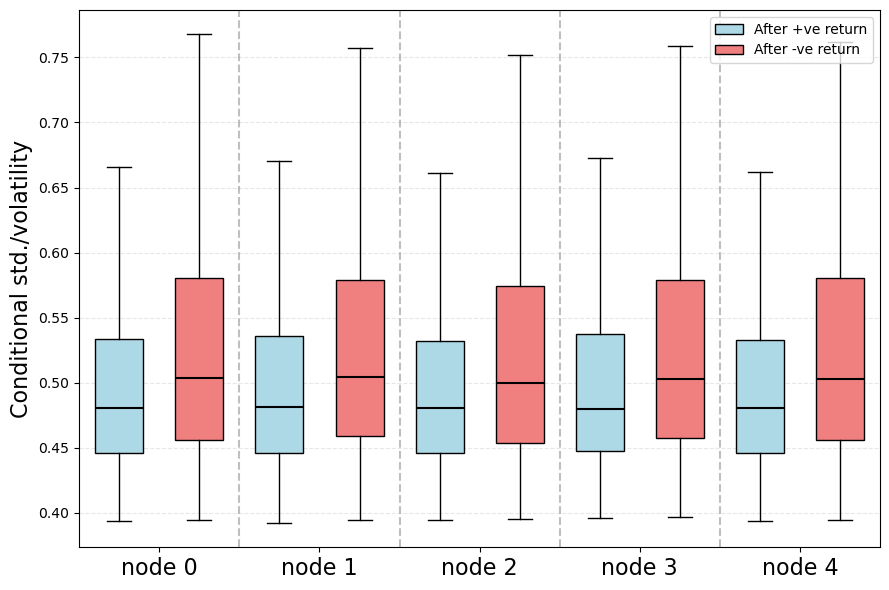

In [35]:
# Step 1: gather 'previous‐return signs' for each node i
# We want sign(X_data[t-1, i]) for t = 1,2,...,T_eff-1, where T_eff = T-burnin
# So we lose the first row of var_data (no previous return for t=0)
T_eff, d = thres_X_data.shape

# Build a (T_eff-1) × d array of previous sign
prev_sign = np.sign(thres_X_data[:-1, :] )   # shape = (T_eff-1, d)
# Now var_data[1:, i] is the variance at t=1,...,T_eff-1 for node i,
# paired with prev_sign[t-1, i] = sign(X_data[t-1, i]).

# Step 2: for each node i, split node variances by whether prev_sign > 0 or < 0
pos_vars_by_node = []
neg_vars_by_node = []

for i in range(d):
    # mask arrays of length T_eff-1
    mask_positive = (prev_sign[:, i] >  0)
    mask_negative = (prev_sign[:, i] <  0)

    # collect node variances at times t=1,...,T_eff-1
    sigma_i = np.sqrt(thres_var_data[1:, i])
    pos_vars_by_node.append(sigma_i[mask_positive])
    neg_vars_by_node.append(sigma_i[mask_negative])

# Step 3: build a side-by-side boxplot for each node
# We will create 2d arrays where boxplot expects a list of arrays, each array = data for one category.
# So we want [pos_vars_node0, neg_vars_node0] for the first panel, then [pos_vars_node1, neg_vars_node1], etc.
data_to_plot = []
xticks = []
xlabels = []
for i in range(d):
    # Append positive group then negative group for node i
    data_to_plot.append(pos_vars_by_node[i])
    data_to_plot.append(neg_vars_by_node[i])
    xticks.append(2*i + 1.5)
    xlabels.append(f'node {i}')

plt.figure(figsize=(9, 6))
box = plt.boxplot(
    data_to_plot,
    widths=0.6,
    patch_artist=True,
    showfliers=False,
    medianprops={'color': 'black', 'linewidth': 1.5},
)

# Coloring: make positive boxes one color, negative boxes a second color
for i in range(d):
    pos_box = box['boxes'][2*i]
    neg_box = box['boxes'][2*i + 1]
    pos_box.set(facecolor='lightblue')
    neg_box.set(facecolor='lightcoral')

# Draw vertical separators between nodes for clarity
for i in range(d-1):
    plt.axvline(x=2*i + 2.5, color='gray', linestyle='--', alpha=0.5)

plt.xticks(xticks, xlabels, rotation=0, fontsize=16)
plt.xlim(0.5, 2*d + 0.5)
plt.ylabel('Conditional std./volatility', fontsize=16)
#plt.title('Conditional variance for nodes, after positive (+ve) or negative (-ve) shock at t-1', fontsize=20)

# Create a custom legend for 'After positive' and 'After negative'
legend_handles = [
    Patch(facecolor='lightblue', edgecolor='k', label='After +ve return'),
    Patch(facecolor='lightcoral', edgecolor='k', label='After -ve return')
]
plt.legend(handles=legend_handles, loc='upper right')

plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()